<a href="https://colab.research.google.com/github/yakkunn7422/public_colab/blob/main/2024_AIC2_thema1_main6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -fr /content/sample_data/new_train_images
!rm -fr /content/sample_data/test_images.zip
!rm -fr /content/sample_data/train_images.zip
!rm -fr /content/sample_data/train_master.tsv
!rm -fr /content/sample_data/sample_submit.tsv
!rm -fr /content/sample_data/resnet18-5c106cde.pth
!rm -fr /content/sample_data/label_master.tsv


In [11]:
import os
import re
from datetime import datetime

# 対象のディレクトリパス
directory_path = 'drive/MyDrive/2024_AIContest2/Thema1/pth'

# ファイル名のパターン
file_pattern = r"original_model_(\d+)\.pth"

# 現在の日付と時間を取得 (yyyymmdd_hhmm)
current_time = datetime.now().strftime("%Y%m%d_%H%M")

# 最大のXXを持つファイルを特定
max_number = -1
file_to_keep = None

# ディレクトリ内のファイルを走査
for file_name in os.listdir(directory_path):
    file_path = os.path.join(directory_path, file_name)

    # 正規表現でファイル名が "original_model_XX.pth" 形式かチェック
    match = re.match(file_pattern, file_name)
    if match:
        number = int(match.group(1))  # XX部分を取得
        if number > max_number:
            max_number = number
            file_to_keep = file_name

# 最も大きい数字を持つファイルに接頭辞を付けてリネーム
if file_to_keep:
    new_file_name = f"{current_time}_{file_to_keep}"
    new_file_path = os.path.join(directory_path, new_file_name)
    os.rename(os.path.join(directory_path, file_to_keep), new_file_path)
    print(f"{file_to_keep} は {new_file_name} にリネームされました。")

# ディレクトリ内のファイルを再度走査して、不要なファイルを削除
for file_name in os.listdir(directory_path):
    file_path = os.path.join(directory_path, file_name)

    # "original_model_XX.pth" 形式のファイルを削除
    match = re.match(file_pattern, file_name)
    if match and file_name != new_file_name:
        try:
            os.remove(file_path)
            print(f"{file_path} は削除されました。")
        except FileNotFoundError:
            print(f"{file_path} は見つかりませんでした。")
        except PermissionError:
            print(f"{file_path} の削除に必要な権限がありません。")
        except Exception as e:
            print(f"{file_path} の削除中にエラーが発生しました: {e}")

original_model_5.pth は 20250403_1137_original_model_5.pth にリネームされました。
drive/MyDrive/2024_AIContest2/Thema1/pth/original_model_0.pth は削除されました。
drive/MyDrive/2024_AIContest2/Thema1/pth/original_model_1.pth は削除されました。
drive/MyDrive/2024_AIContest2/Thema1/pth/original_model_2.pth は削除されました。
drive/MyDrive/2024_AIContest2/Thema1/pth/original_model_3.pth は削除されました。
drive/MyDrive/2024_AIContest2/Thema1/pth/original_model_4.pth は削除されました。


In [2]:
import os
print("カレントワーキングディレクトリは[" + os.getcwd() + "]です")

カレントワーキングディレクトリは[/content]です


In [3]:
# sample_data 配下にResnet18使う際のデータ一式を持ってくるコード

import os
import pandas as pd
import zipfile
import shutil
import numpy as np

#パラメータ
TRAIN_RATIO = 0.8



#trainイメージファイル、testイメージファイル等のファイル格納先
input_dir = '/content/drive/MyDrive/2024_AIContest2/Thema1'
work_dir =  '/content/sample_data'

#trainデータの解凍・成形先のディレクトリ
output_dir = os.path.join(work_dir, 'new_train_images')

#trainデータファイル名
zip_file_path = os.path.join(work_dir, 'train_images.zip')
#trainデータのラベルまとめファイル名
tsv_file_path = os.path.join(work_dir, 'train_master.tsv')

# ファイルをCOPYする
def simple_copy_files(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)  # コピー先ディレクトリを作成（既に存在する場合は何もしない）

    for file_name in os.listdir(src_dir):
        full_file_name = os.path.join(src_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy2(full_file_name, dst_dir)  # ファイルのコピー

# トレインとバリデーション用のディレクトリおよびその中のラベルごとのサブディレクトリを作成する
def create_directories(base_dir, labels):

    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')

    for dir_path in [train_dir, val_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    for label in labels:
        os.makedirs(os.path.join(train_dir, str(label)), exist_ok=True)
        os.makedirs(os.path.join(val_dir, str(label)), exist_ok=True)

    return train_dir, val_dir

# ZIPファイルを解凍する
def extract_zip(zip_file_path, extract_to):

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# TSVファイルを読み込み、1行目を削除してデータフレームを準備する
def load_and_prepare_data(tsv_file_path):

    df = pd.read_csv(tsv_file_path, sep='\t', names=['filename', 'label_id'])
    df = df.iloc[1:].reset_index(drop=True)

    return df

# 画像ファイルをディレクトリに分配する
def distribute_images(df, image_dir, train_dir, val_dir, train_ratio=0.8):

    for label in df['label_id'].unique():
        label_images = df[df['label_id'] == label]['filename'].tolist()
        # シャッフルして分割

        np.random.shuffle(label_images)
        train_size = int(len(label_images) * train_ratio)
        train_images = label_images[:train_size]
        val_images = label_images[train_size:]

        for image_name in train_images:
            src_path = os.path.join(image_dir, image_name)
            dst_path = os.path.join(train_dir, str(label), image_name)
            shutil.copy(src_path, dst_path)

        for image_name in val_images:
            src_path = os.path.join(image_dir, image_name)
            dst_path = os.path.join(val_dir, str(label), image_name)
            shutil.copy(src_path, dst_path)

# ディレクトリ内のアイテムを探索し数を表示する
def count_files_recursive(directory):
    total_files = 0

    for root, dirs, files in os.walk(directory):
        files_count = len(files)
        subdir_relative = os.path.relpath(root, directory)
        print(f"Directory '{subdir_relative}' contains {files_count} files.")

        total_files += files_count

    print(f"Total files in '{directory}': {total_files}")

# メイン処理を実行する関数
def main(zip_file_path, tsv_file_path, output_dir, train_ratio=0.8):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df = load_and_prepare_data(tsv_file_path)

    extract_zip(zip_file_path, output_dir)

    labels = df['label_id'].unique()

    train_dir, val_dir = create_directories(output_dir, labels)
    image_dir = os.path.join(output_dir, 'train_images')

    distribute_images(df, image_dir, train_dir, val_dir, train_ratio)

    # 解凍後のディレクトリを削除
    if os.path.exists(image_dir):
        shutil.rmtree(image_dir)
        print(f"Deleted temporary directory: {image_dir}")

# 実行
# INPUTディレクトリのファイルをOUTPUTディレクトリにすべてCOPY
simple_copy_files(input_dir,work_dir)
# Train.zipファイル内の画像をtrain、val毎(割合い0.8)かつラベル毎のディレクトリに配置
main(zip_file_path, tsv_file_path, output_dir, train_ratio = TRAIN_RATIO)

count_files_recursive(output_dir)


Deleted temporary directory: /content/sample_data/new_train_images/train_images
Directory '.' contains 0 files.
Directory 'train' contains 0 files.
Directory 'train/4' contains 400 files.
Directory 'train/1' contains 400 files.
Directory 'train/2' contains 400 files.
Directory 'train/8' contains 400 files.
Directory 'train/0' contains 400 files.
Directory 'train/3' contains 400 files.
Directory 'train/6' contains 400 files.
Directory 'train/5' contains 400 files.
Directory 'train/7' contains 400 files.
Directory 'train/9' contains 400 files.
Directory 'val' contains 0 files.
Directory 'val/4' contains 100 files.
Directory 'val/1' contains 100 files.
Directory 'val/2' contains 100 files.
Directory 'val/8' contains 100 files.
Directory 'val/0' contains 100 files.
Directory 'val/3' contains 100 files.
Directory 'val/6' contains 100 files.
Directory 'val/5' contains 100 files.
Directory 'val/7' contains 100 files.
Directory 'val/9' contains 100 files.
Total files in '/content/sample_data/n

train:フェイズ
   loaders:1回目    loss:2.397122383117676
   loaders:2回目    loss:2.3247852325439453
   loaders:3回目    loss:2.3156685829162598
   loaders:4回目    loss:2.0882112979888916
   loaders:5回目    loss:2.0437989234924316
   loaders:6回目    loss:1.9529752731323242
   loaders:7回目    loss:1.943239450454712
   loaders:8回目    loss:1.781185269355774
   loaders:9回目    loss:1.660354495048523
   loaders:10回目    loss:1.552290916442871
   loaders:11回目    loss:1.4171197414398193
   loaders:12回目    loss:1.356391429901123
   loaders:13回目    loss:1.3381966352462769
   loaders:14回目    loss:1.1292701959609985
   loaders:15回目    loss:1.0804439783096313
   loaders:16回目    loss:1.009869933128357
   loaders:17回目    loss:1.0675504207611084
   loaders:18回目    loss:0.8879752159118652
   loaders:19回目    loss:0.8868027329444885
   loaders:20回目    loss:0.760536789894104
   loaders:21回目    loss:0.7129538059234619
   loaders:22回目    loss:0.6290506720542908
   loaders:23回目    loss:0.6653704643249512
   loaders:24回目  

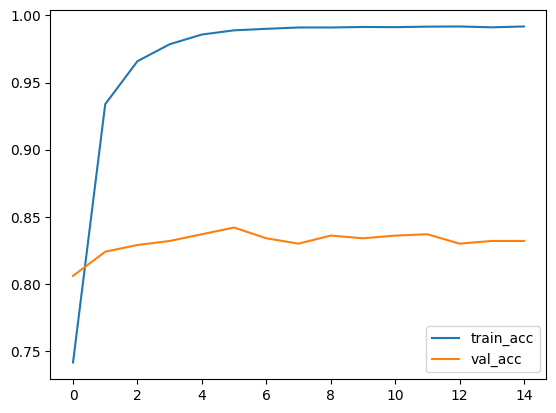

In [10]:
# Resnet18で学習
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations
from torch.utils.data import Dataset, ConcatDataset
from torchvision import datasets, models, transforms
from PIL import Image, ImageFilter

input_dir = '/content/drive/MyDrive/2024_AIContest2/Thema1'
work_dir =  '/content/sample_data'


#定数設定
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_NUM = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.005
EPOCH = 15
TRANSFER_LEARNING = True
MODEL_LEARNING = True

#transforms定義
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'train_flipped': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(p=1.0),  # 常に反転
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# dataset追加対応
# --- ここから
train_dataset = datasets.ImageFolder('/content/sample_data/new_train_images/train', data_transforms['train'])
train_dataset_flipped = datasets.ImageFolder('/content/sample_data/new_train_images/train', data_transforms['train_flipped'])

# 元のデータセットと反転データセットを結合
combined_train_dataset = ConcatDataset([train_dataset, train_dataset_flipped])

image_datasets = {
    'train': combined_train_dataset,  # 結合されたデータセットを使用
    'val': datasets.ImageFolder('/content/sample_data/new_train_images/val', data_transforms['val']),
}
# --- ここまで
#dataset作成(旧)
#image_datasets = {
#    'train': datasets.ImageFolder('/content/sample_data/new_train_images/train',data_transforms['train']),
#    'val': datasets.ImageFolder('/content/sample_data/new_train_images/val',data_transforms['val'])
#}

#dataloaders作成
image_dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True),
}

#dataサイズ定義
dataset_sizes= {
    'train':len(image_datasets['train']),
    'val':len(image_datasets['val'])
}

#ResNet18モデル定義
def get_model(target_num,isPretrained=False):

    if(isPretrained):
        model_ft = models.resnet18(pretrained=False)
        model_ft.load_state_dict(torch.load(os.path.join(work_dir, '/content/sample_data/resnet18-5c106cde.pth'), map_location=lambda storage, loc: storage,weights_only=False), strict=True)
    else:
        model_ft = models.resnet18(pretrained=False)

    model_ft.fc = nn.Linear(512, target_num)
    model_ft = model_ft.to(DEVICE)
    return model_ft

if not MODEL_LEARNING:
    print("処理を停止します。")
    sys.exit()  # プログラムを終了

#モデルのインスタンス作成 転移学習なし（FALSE）
model_ft = get_model(target_num=TARGET_NUM,isPretrained=TRANSFER_LEARNING)

#最適化関数定義
optimizer = optim.SGD(model_ft.parameters(),lr=LEARNING_RATE, momentum=0.9)

#loss関数定義
criterion = nn.CrossEntropyLoss()

#モデル訓練用関数
def train_model(model, criterion, optimizer, num_epochs=5,is_saved = False):
    best_acc = 0.0


    train_arr1 = np.zeros(EPOCH)
    val_arr1   = np.zeros(EPOCH)

    # エポック数だけ下記工程の繰り返し
    for epoch in range(num_epochs):

        for phase in ['train', 'val']:
            print('{}:フェイズ'.format(phase))

            # 訓練フェイズと検証フェイズの切り替え
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # dataloadersからバッチサイズだけデータ取り出し、下記工程（1−5）の繰り返し
            for i,(inputs, labels) in enumerate(image_dataloaders[phase]):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # 1. optimizerの勾配初期化
                optimizer.zero_grad()

                # 2.モデルに入力データをinputし、outputを取り出す
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                # 3. outputと正解ラベルから、lossを算出
                loss = criterion(outputs, labels)
                print('   loaders:{}回目'.format(i+1)  ,'   loss:{}'.format(loss))

                if phase == 'train':
                    # 4. 誤差逆伝播法により勾配の算出
                    loss.backward()
                    # 5. optimizerのパラメータ更新
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('EPOCH{}回目 {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_arr1[epoch]=epoch_acc
            else:
                val_arr1[epoch]=epoch_acc

            # C. 今までのエポックでの精度よりも高い場合はモデルの保存
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                if(is_saved):
                    print('Save File original_model_{}.pth'.format(epoch))
                    torch.save(model.state_dict(), '/content/drive/MyDrive/2024_AIContest2/Thema1/pth/original_model_{}.pth'.format(epoch))


    print('Best val Acc: {:4f}'.format(best_acc))
    print(train_arr1)
    print(val_arr1)
    train_ser1 = pd.Series(train_arr1,name='train_acc')
    result_data = pd.DataFrame(train_ser1)
    result_data['val_acc']=val_arr1
    result_data.plot()
    plt.show()

train_model(model = model_ft,criterion = criterion,optimizer = optimizer,num_epochs=EPOCH,is_saved = True)


In [13]:
#学習したモデルを使ってtestデータの推論を実施
import pandas as pd
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from PIL import Image, ImageFilter

work_dir           = '/content/sample_data'
save_dir           = '/content/drive/MyDrive/2024_AIContest2/Thema1/'
test_zip_file_path = '/content/sample_data/test_images.zip'
test_file_dir      = os.path.join(work_dir, 'test_images')
report_format_tsv  = os.path.join(work_dir, 'sample_submit.tsv')
best_model_path    = os.path.join(save_dir, 'pth/20250403_1137_original_model_5.pth')
output_file        = os.path.join(save_dir, 'output/20250402_out_submit_4.tsv')

TARGET_NUM = 10

# ZIPファイルを解凍する
def extract_zip(zip_file_path, extract_to):

    if not os.path.exists(test_file_dir):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

extract_zip(test_zip_file_path, work_dir)

#dataサイズ定義
dataset_sizes= {
    'train':len(image_datasets['train']),
    'val':len(image_datasets['val'])
}

#submit用dataset定義
class For_Submission_Datasets(Dataset):

    def __init__(self, data_transform):
        self.df = pd.read_csv(report_format_tsv ,sep='\t',names=['filename','target'])
        self.data_transform = data_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        file = self.df['filename'][index]
        image = Image.open(test_file_dir +'/'+ file)
        image = self.data_transform(image)

        return image,file

#submit用dataset作成
subdataset = For_Submission_Datasets(data_transform=data_transforms['val'])

#submit用dataloaders作成
subdataloader = torch.utils.data.DataLoader(subdataset, batch_size=1, shuffle=False, num_workers=0, drop_last=True)

#精度の最も高いモデルをロード
#モデルの名前を適宜変更して、最も精度の高いモデルをロードしましょう
best_model = get_model(target_num = TARGET_NUM)
best_model.load_state_dict(torch.load(best_model_path, map_location=lambda storage, loc: storage), strict=True)

submit = pd.read_csv(report_format_tsv,sep='\t', header=None)
#print(submit)
#テストデータに対しての推論
pred = []
for i,(inputs, labels) in enumerate(subdataloader):
    inputs = inputs.to(DEVICE)
    best_model.eval()
    outputs = best_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred.append(preds.item())

df_test = pd.read_csv(report_format_tsv ,sep='\t',names=['filename','target'])

df_test['pred'] = pred
#print(df_test)
submit[1] = pred

submit.to_csv(output_file ,sep='\t', index=False, header=False)
print(submit)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


                  0  1
0        test_0.jpg  6
1        test_1.jpg  7
2        test_2.jpg  5
3        test_3.jpg  0
4        test_4.jpg  3
...             ... ..
7995  test_7995.jpg  9
7996  test_7996.jpg  6
7997  test_7997.jpg  8
7998  test_7998.jpg  8
7999  test_7999.jpg  8

[8000 rows x 2 columns]
